# Arrival Time Prediction - Synchronisation
This notebook is the third on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function for each segment that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point.

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats 
import math
import tensorflow as tf
import plot
import GPy

train = pd.read_pickle('train.pkl')
support = pd.read_pickle('support.pkl')
sns.set(style="darkgrid")
np.random.seed(1)

## Hyperparameter Priors
The synchronisation function is a function f : R^2 -> [0, 1] so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance. We will not use this in the conventional sense of learning parameters using MAP (Maximum aposteriori), but for performing random restarts while learning using ML (Maximum likelihood). This needs to be done since GPs are quite prone to getting stuck in local minimas. Let's start with the kernel lengthscale parameter.

### Kernel Lenghtscale (*l*)
When the data was downsampled in the pre processing, it was done with *delta* = 3e-2. Based on this we have implicitly said that points that have a distance of delta are close by, so the lengthscale prior should reflect that.

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

The goal is to find an *l* of the RBF that makes it wide enough to consider points within delta distance as close. Trying some different values shows that *l* = 0.25 gives something that would consider the closest 10 points close and then decay noticeably.

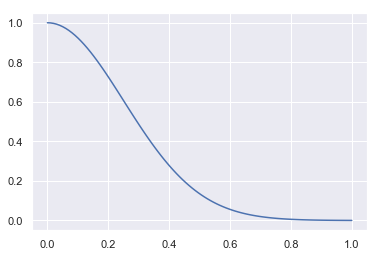

In [2]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 1
xx = np.linspace(xmin, xmax, 100)[:,None]
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.25)[:,0])

Having concluded a value of *l* that makes sense, we now put a distribution over *l* with its mean around the chosen value and a variance representing our certainty. I am not too certain in my belief, and believe that *l* could take on values quite a bit bigger than the mean value. Since the length scale is strictly positive I've chosen a gamma distribution, which it can be seen in the plot below. This is our length scale prior!

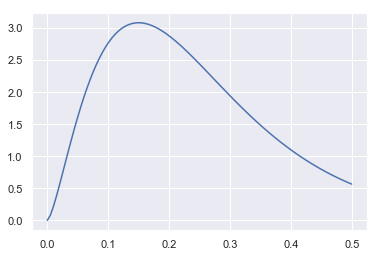

In [3]:
xmin = 0
xmax = 0.5
l_alpha = 2.5
l_theta = 0.1
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=l_alpha, scale=l_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance (*sigmaf*)
The kernel variance determines the average distance that the function output has from the function mean. Since the output of the function is on [0, 1], the output should not need to vary more than this. To prevent overfitting a *sigmaf* of 0.6 seems right, but let's go with quite high uncertainty on this one. Since it is also a strictly positive quantity a gamma distribution is used here as well, like with the lengthscale.

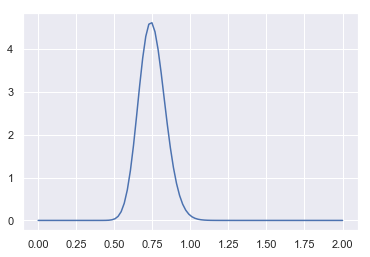

In [4]:
xmin = 0
xmax = 2
sigmaf_alpha = 75
sigmaf_theta = 0.01
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigmaf_alpha, scale=sigmaf_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance (*sigma*)
We also need to chose a prior for the likelihood variance *sigma*, which representas the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

In the provided thesis the average GPS variance of a smartphone is claimed to be *sigma* = 10^-5 so we'll go with that, but like with *sigmaf* we will be quite uncertain.

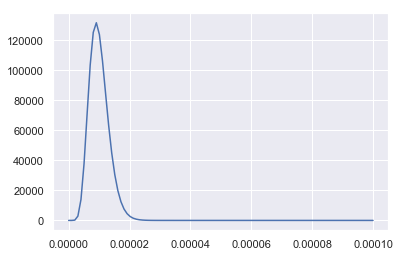

In [5]:
xmin = 0
xmax = 0.0001
sigma_alpha = 10
sigma_theta = 0.000001
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigma_alpha, scale=sigma_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

# Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation. This works because the model is used to interpolation and has consequently no need to generalise. We use both the training and support data for this model, for reasons mentioned in notebook 1.

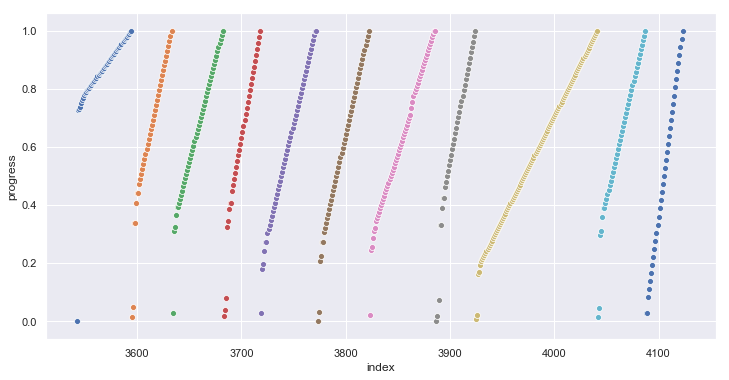

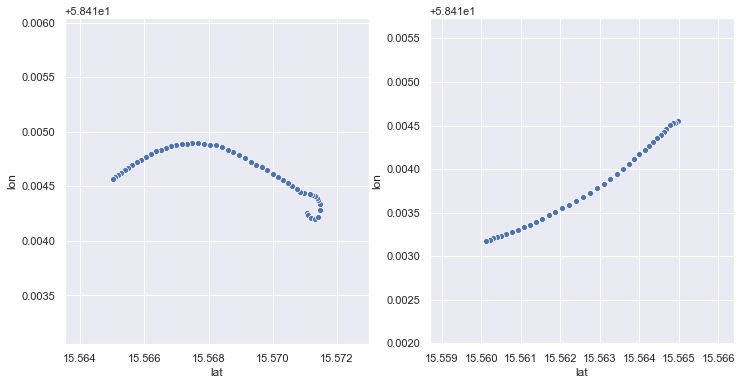

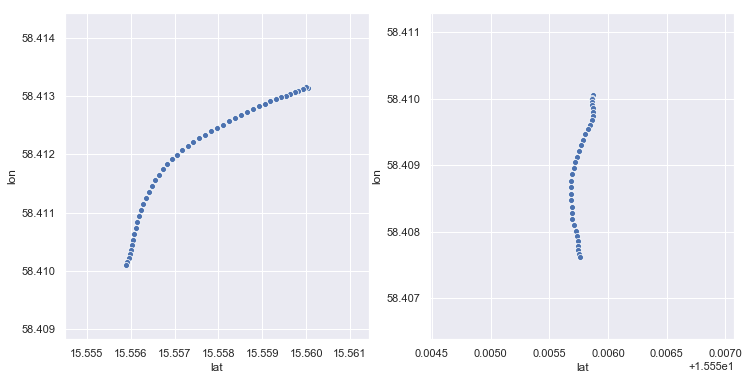

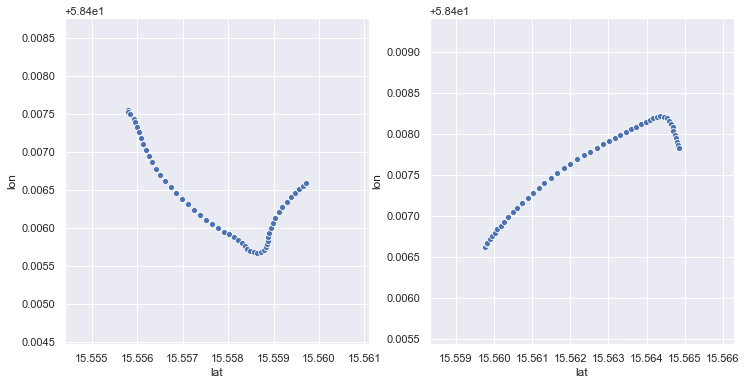

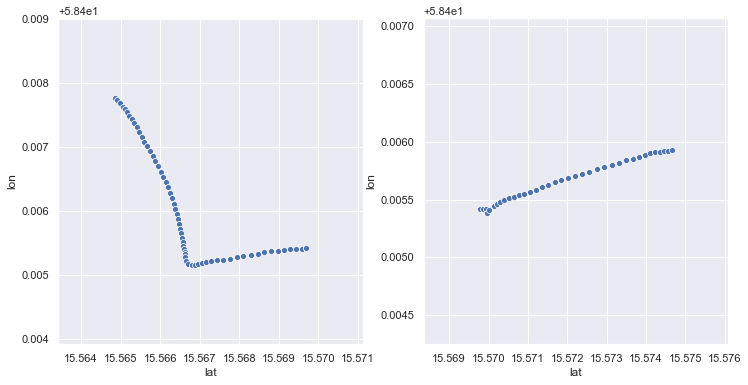

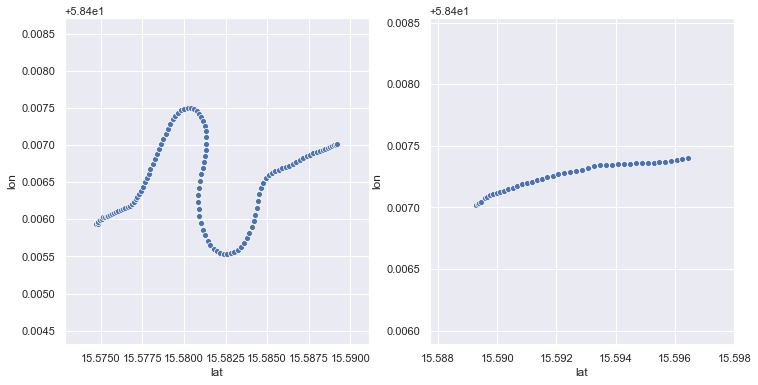

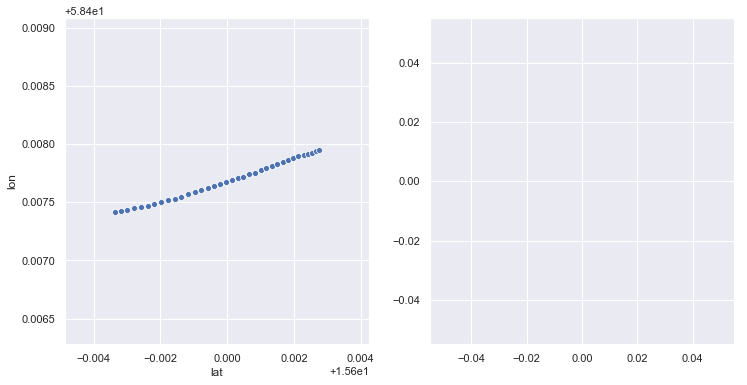

In [6]:
n_trajs = train.traj.unique()
traj_n = n_trajs[3] # 1: decent
traj = train[train.traj == traj_n]
plot.traj_progress(traj)
plot.traj_segment_grid(traj)

Having found a seg_n that seems typical we can now fit GPs for each of its segments. As mentioned, we'll merge the train and support data for this.

In [8]:
from sklearn.preprocessing import scale

def train_gp(seg):
    X = scale(seg[['lat', 'lon']].values)
    y = scale(seg[['progress']].values)
    k = GPy.kern.RBF(input_dim=X.shape[1], variance=1., lengthscale=1.)
    model = GPy.models.GPRegression(X, y, k)
    model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.25, 0.001))
    model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.1))
    model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.01, 0.01))
    model.optimize_restarts(5)
    return model

n_segs = traj.seg.unique()
gps = [train_gp(traj[traj.seg == seg_n]) for seg_n in n_segs]

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 71.22476894038564
Optimization restart 2/5, f = 119856.12720720093
Optimization restart 3/5, f = 119855.69987620942


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 119858.54412006929
Optimization restart 5/5, f = 119855.78648653827
Optimization restart 1/5, f = 26.283856531362893
Optimization restart 2/5, f = 4743990.532594248
Optimization restart 3/5, f = 26.283856531391912


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 26.283856531365473
Optimization restart 5/5, f = 4743988.536156316
Optimization restart 1/5, f = 22.09019354616275
Optimization restart 2/5, f = 22.09019354620488
Optimization restart 3/5, f = 6168312.570632506


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 6168316.342902311
Optimization restart 5/5, f = 22.090193546174607
Optimization restart 1/5, f = 31.676701380873382
Optimization restart 2/5, f = 2545909.244821255
Optimization restart 3/5, f = 31.676701381378333
Optimization restart 4/5, f = 2545909.784766606


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 2545911.350412761
Optimization restart 1/5, f = 4.140216960095902
Optimization restart 2/5, f = 3411185.99497572
Optimization restart 3/5, f = 4.140216962372223
Optimization restart 4/5, f = 3411186.3457937427
Optimization restart 5/5, f = 3411185.7348785405
Optimization restart 1/5, f = 4.802454555701423


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = 1648527.6458593481
Optimization restart 3/5, f = 4.802454555710645
Optimization restart 4/5, f = 1648523.9749618664
Optimization restart 5/5, f = 4.8024545557027745
Optimization restart 1/5, f = 7.490088103681863
Optimization restart 2/5, f = 2850664.011825254
Optimization restart 3/5, f = 2850663.9401268917
Optimization restart 4/5, f = 2850664.083195995
Optimization restart 5/5, f = 7.4900881036808435


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 14.878636547531226
Optimization restart 2/5, f = 14.878636547462488
Optimization restart 3/5, f = 3288142.078233246
Optimization restart 4/5, f = 3288141.387454629
Optimization restart 5/5, f = 3288141.887579964
Optimization restart 1/5, f = -107.38519445226805
Optimization restart 2/5, f = -107.38519445233744
Optimization restart 3/5, f = -107.38519445229642


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -107.38519445235544
Optimization restart 5/5, f = -107.3851944523525
Optimization restart 1/5, f = 14.276100698707591


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = 6361710.264371437
Optimization restart 3/5, f = 14.276100698707795
Optimization restart 4/5, f = 14.27610069870769
Optimization restart 5/5, f = 6361710.647528925
Optimization restart 1/5, f = -40.46797100929208
Optimization restart 2/5, f = -40.46797100958512


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:119: RuntimeWarning:overflow encountered in expm1
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:121: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/5, f = -40.46797100880426
Optimization restart 4/5, f = -40.467971009614
Optimization restart 5/5, f = -40.46797100948999


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\

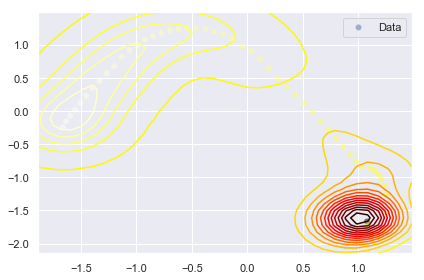

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


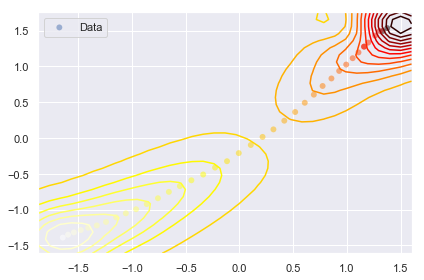

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


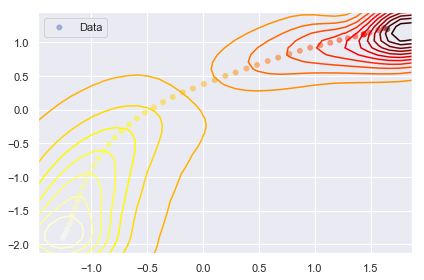

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


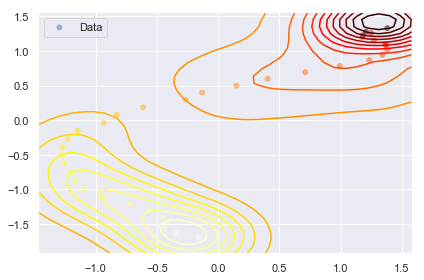

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


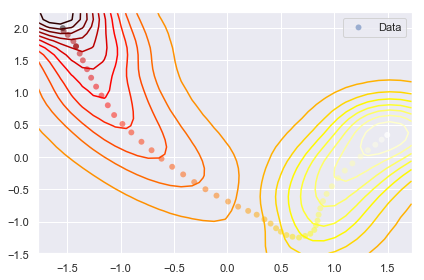

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


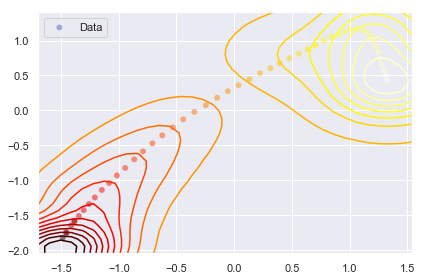

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


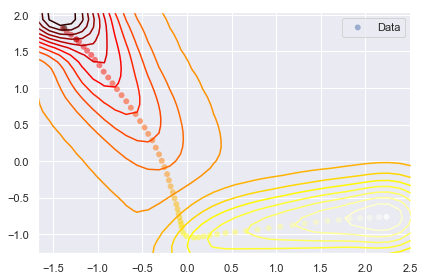

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


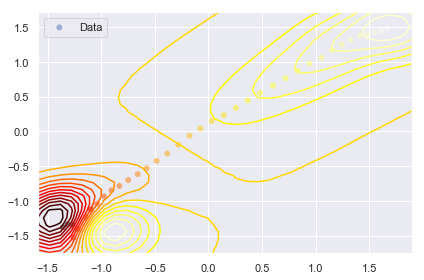

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


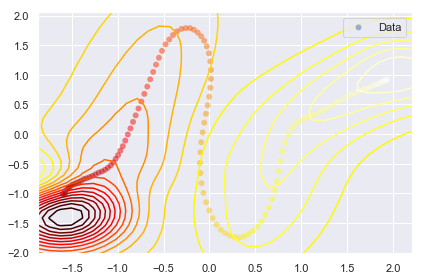

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


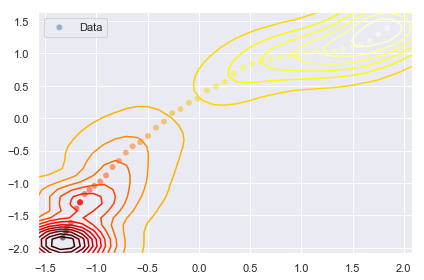

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


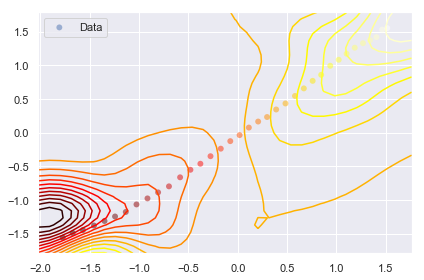

In [9]:
def plot_gps(gps):
    for gp in gps:
        gp.plot()

plot_gps(gps)

Turns out that using the support data made the matrix that needs to be inverted to compute the posterior singular. Huh. So the above computations is indeed done without the support data. 

It's really hard to get a model to fit all the routes perfectly, but hopefully the plots above look pretty enough and we can store them for use in the prediction step.

In [11]:
import gp_gpy as gp
for seg_n, synch_gp in zip(n_segs, gps):
     gp.save(synch_gp, 'synch', traj_n, seg_n)   


Name : GP regression
Objective : 71.22476894038564
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |      priors     
  rbf.variance             |   0.5062580060846726  |      +ve      |    Ga(2.5, 5)   
  rbf.lengthscale          |  0.25886782980179535  |      +ve      |  Ga(62, 2.5e+02)
  Gaussian_noise.variance  |   0.4298729790548935  |      +ve      |    Ga(0.01, 1)  
synch
7.0
1.0

Name : GP regression
Objective : 26.283856531362893
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |      priors     
  rbf.variance             |    0.6698392024240376  |      +ve      |    Ga(2.5, 5)   
  rbf.lengthscale          |   0.28839094113108493  |      +ve      |  Ga(62, 2.5e+02)
  Gaussian_noise.variance  |  0.047255245911714094  |      +ve      |    Ga(0.01, 1)  
synch
7.0